# Importing Utilities

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from sklearn.datasets import fetch_20newsgroups
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

## Reading data

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

## Preprocessing data

In [6]:
stemmer = SnowballStemmer("english")

In [7]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [8]:
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))

In [9]:
dictionary = gensim.corpora.Dictionary(processed_docs)

## Computing coherence of each model to decide on the parameters

In [10]:
from gensim.models import CoherenceModel

In [17]:
def compute_coherence_values(dictionary, processed_docs, limit, start, step):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        for min_df_step in range(10,110,10):
            dictionary.filter_extremes(no_below=min_df_step, no_above=0.1, keep_n= 100000)
            bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
            lsi_model = gensim.models.lsimodel.LsiModel(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics)
            model_list.append(lsi_model)
            coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherence_model_lsi.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, processed_docs=processed_docs, start=50, limit=250, step=50)


In [22]:
for m,n in zip(model_list,coherence_values):
    print(m,n)

LsiModel(num_terms=8672, num_topics=50, decay=1.0, chunksize=20000) 0.373054544291632
LsiModel(num_terms=5375, num_topics=50, decay=1.0, chunksize=20000) 0.372026711301835
LsiModel(num_terms=4033, num_topics=50, decay=1.0, chunksize=20000) 0.34106090356141594
LsiModel(num_terms=3309, num_topics=50, decay=1.0, chunksize=20000) 0.35715776332502963
LsiModel(num_terms=2835, num_topics=50, decay=1.0, chunksize=20000) 0.3400759802706687
LsiModel(num_terms=2476, num_topics=50, decay=1.0, chunksize=20000) 0.3362204387813874
LsiModel(num_terms=2195, num_topics=50, decay=1.0, chunksize=20000) 0.3387405561908693
LsiModel(num_terms=1963, num_topics=50, decay=1.0, chunksize=20000) 0.3328016095783436
LsiModel(num_terms=1784, num_topics=50, decay=1.0, chunksize=20000) 0.35887481955102984
LsiModel(num_terms=1630, num_topics=50, decay=1.0, chunksize=20000) 0.33116409287404286
LsiModel(num_terms=1630, num_topics=100, decay=1.0, chunksize=20000) 0.2820444461486742
LsiModel(num_terms=1630, num_topics=100,

## From above results it seems best parameters are -  Num of topics = 50, min_df = 0.1 or 10%

In [25]:
# Build LSI model
dictionary.filter_extremes(no_below=10, no_above=0.1, keep_n= 100000) #min_df = 10
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lsi_model50 = gensim.models.lsimodel.LsiModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=50)

In [27]:
from pprint import pprint #pretty print
# Print the Keyword in the topics
pprint(lsi_model50.print_topics())
doc_lsi50 = lsi_model50[bow_corpus]

[(0,
  '0.485*"file" + 0.223*"program" + 0.194*"imag" + 0.148*"avail" + '
  '0.144*"entri" + 0.125*"window" + 0.114*"version" + 0.112*"anonym" + '
  '0.111*"output" + 0.106*"data"'),
 (1,
  '-0.582*"file" + -0.311*"entri" + -0.250*"output" + 0.150*"wire" + '
  '0.101*"drive" + 0.093*"anonym" + 0.090*"data" + -0.089*"program" + '
  '-0.086*"section" + 0.086*"avail"'),
 (2,
  '-0.398*"imag" + 0.188*"wire" + -0.168*"avail" + -0.159*"window" + '
  '-0.149*"version" + 0.139*"entri" + -0.139*"format" + -0.139*"graphic" + '
  '-0.137*"color" + -0.135*"widget"'),
 (3,
  '-0.543*"wire" + 0.326*"anonym" + -0.211*"entri" + 0.201*"privaci" + '
  '0.192*"internet" + -0.161*"circuit" + -0.128*"grind" + 0.126*"file" + '
  '-0.121*"connect" + 0.106*"user"'),
 (4,
  '0.492*"wire" + 0.281*"anonym" + 0.171*"privaci" + 0.164*"internet" + '
  '-0.153*"entri" + -0.152*"drive" + 0.148*"file" + 0.145*"circuit" + '
  '-0.138*"team" + -0.136*"armenian"'),
 (5,
  '-0.434*"entri" + 0.369*"file" + 0.274*"drive" + 

## Building multiclass classifier

In [42]:
#Reading data
newsgroup_data = fetch_20newsgroups(shuffle=True)

In [43]:
#Vectorizing the data using TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(newsgroup_data.data).toarray()

labels = newsgroup_data.target


In [44]:
# Doing Cross Validation on various models and checking its accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/anaconda3/envs/ropulus_v2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/ropulus_v2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/ropulus_v2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/ropulus_v2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/ropulus_v2/lib/python3.6/site-packages/skl

In [45]:
#Checking which model performs better
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.922497
LogisticRegression        0.897302
MultinomialNB             0.869367
RandomForestClassifier    0.625784
Name: accuracy, dtype: float64

In [50]:
# Using Linear SVM as it gives best accuracy
model = LinearSVC()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

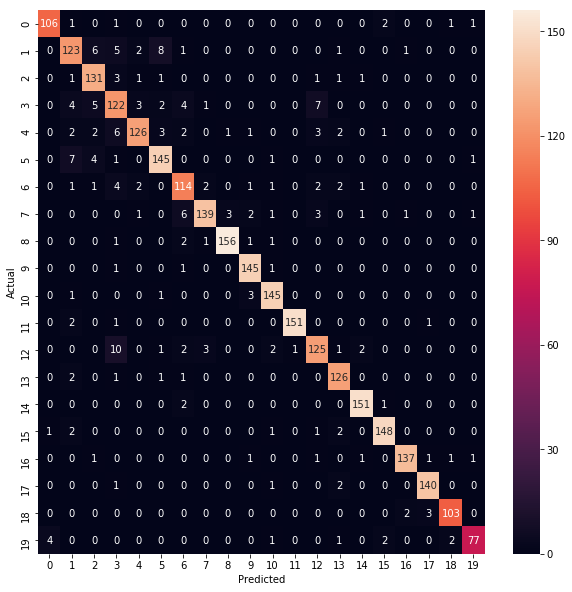

In [54]:
# Checking confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:
# Showing entire classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=newsgroup_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.95      0.95      0.95       112
           comp.graphics       0.84      0.84      0.84       147
 comp.os.ms-windows.misc       0.87      0.94      0.90       140
comp.sys.ibm.pc.hardware       0.78      0.82      0.80       148
   comp.sys.mac.hardware       0.93      0.85      0.89       149
          comp.windows.x       0.90      0.91      0.90       159
            misc.forsale       0.84      0.87      0.86       131
               rec.autos       0.95      0.88      0.91       158
         rec.motorcycles       0.97      0.96      0.97       162
      rec.sport.baseball       0.94      0.98      0.96       148
        rec.sport.hockey       0.94      0.97      0.95       150
               sci.crypt       0.99      0.97      0.98       155
         sci.electronics       0.87      0.85      0.86       147
                 sci.med       0.91      0.96      0.94       131
         